To run Atla-Selene-Mini within this notebook, you should use a **GPU with >= 16GB VRAM**. If you are using this notebook within Colab, we recommend changing your Runtime to a **T4 or above** - you can do this by going to `Runtime`→`Change runtime type` and change the `Hardware accelerator`.

# Setup

## Install packages + verify hardware

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Double check you are using a GPU:

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Atla Selene Mini (Model + Tokenizer)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

atla_model_id = "AtlaAI/Selene-1-Mini-Llama-3.1-8B"

atla_model = AutoModelForCausalLM.from_pretrained(atla_model_id, device_map="auto") # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues
atla_tokenizer = AutoTokenizer.from_pretrained(atla_model_id) # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

### Let's test out the model!

In [ ]:
prompt = "I heard you can evaluate my responses?" # replace with your eval prompt

messages = [{"role": "user", "content": prompt}]
text = atla_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = atla_tokenizer([text], return_tensors="pt").to(device)

generated_ids = atla_model.generate(model_inputs.input_ids, max_new_tokens=512, temperature = 0.01, do_sample=True, pad_token_id=atla_tokenizer.eos_token_id)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

response = atla_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


I can provide feedback on your responses in various ways. Here are some aspects I can evaluate:

1. **Grammar and syntax**: I can check for grammatical errors, punctuation, and syntax issues in your sentences.
2. **Clarity**: I can assess how clear your message is, ensuring it's easy to understand.
3. **Relevance**: I can evaluate whether your response is relevant to the topic or question at hand.
4. **Coherence**: I can check if your ideas flow logically and are well-organized.
5. **Tone and style**: I can provide feedback on the tone and style of your writing, suggesting improvements for better engagement or clarity.
6. **Length**: I can suggest whether your response is too long or too short for the context.
7. **Specificity**: I can evaluate if your response provides enough detail or specificity to address the question or topic.

If you'd like, you can share a response, and I'll provide feedback on these aspects.


## Load our hallucination test data

We load test data from the publicly accessible [RAGTruth](https://arxiv.org/abs/2401.00396) benchmark - a large-scale corpus of naturally generated hallucinations, featuring detailed word-level annotations specifically designed for retrieval-augmented generation (RAG) scenarios. The data has 'undergone meticulous manual annotations at both the individual cases and word levels, incorporating evaluations of hallucination intensity'.

We access these test samples from the following [Hugging Face dataset](https://huggingface.co/datasets/flowaicom/RAGTruth_test).

In [ ]:
from datasets import load_dataset
from itertools import islice

# Load only the first 25 samples
RAGTruth_dataset = load_dataset("flowaicom/RAGTruth_test", split="qa", streaming=True) # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues
RAGTruth_dataset = list(islice(RAGTruth_dataset, 25))


README.md:   0%|          | 0.00/4.23k [00:00<?, ?B/s]

In [ ]:
import pandas as pd

# Convert to df
df = pd.DataFrame(RAGTruth_dataset)
pd.set_option("display.max_colwidth", 500)

In [ ]:
df.head()

,id,response,score,task_type,source,source_info,prompt
0,11904,"Automotive technicians can be paid in various ways depending on factors such as where they work, whether they are paid commission, how much they earn, and the state in which they work. Some may be entitled to overtime under certain conditions. They can be paid based on different combinations of hourly and commission rates, which can vary depending on their specialization. The amount they earn can also vary depending on geographical location. For example, automotive technicians in Alaska have...",1,QA,MARCO,"{""question"": ""how do automotive technicians get paid"", ""passages"": ""passage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair shop), (b) how they are paid (commission or not), (c) how much they make (regular hourly rate and commissions), and (d) the state in which they work.d 1554, finding that certain automotive mechanics and technicians paid on a flat-rate or flag-rate are entitled to overtime under the FLSA.\...","Briefly answer the following question:\nhow do automotive technicians get paid\nBear in mind that your response should be strictly based on the following three passages:\npassage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair shop), (b) how they are paid (commission or not), (c) how much they make (regular hourly rate and commissions), and (d) the state in which they work.d 1554, finding that certain automoti..."
1,11905,"Automotive technicians can be paid through a combination of hourly wages and commissions. The specific amount of pay can vary depending on factors such as the type of work specialization and the company they work for. The location and state in which they work also play a role in determining their pay. For example, technicians in Alaska have the highest average pay, while those in aerospace products and parts manufacturing generally earn a higher wage. However, without further information, it...",1,QA,MARCO,"{""question"": ""how do automotive technicians get paid"", ""passages"": ""passage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair shop), (b) how they are paid (commission or not), (c) how much they make (regular hourly rate and commissions), and (d) the state in which they work.d 1554, finding that certain automotive mechanics and technicians paid on a flat-rate or flag-rate are entitled to overtime under the FLSA.\...","Briefly answer the following question:\nhow do automotive technicians get paid\nBear in mind that your response should be strictly based on the following three passages:\npassage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair shop), (b) how they are paid (commission or not), (c) how much they make (regular hourly rate and commissions), and (d) the state in which they work.d 1554, finding that certain automoti..."
2,11906,Unable to answer based on given passages.,1,QA,MARCO,"{""question"": ""how do automotive technicians get paid"", ""passages"": ""passage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair shop), (b) how they are paid (commission or not), (c) how much they make (regular hourly rate and commissions), and (d) the state in which they work.d 1554, finding that certain automotive mechanics and technicians paid on a flat-rate or flag-rate are entitled to overtime under the FLSA.\...","Briefly answer the following question:\nhow do automotive technicians get paid\nBear in mind that your response should be strictly based on the following three passages:\npassage 1:In short, whether mechanics and technicians are entitled to overtime wages depends on (a) where they work (auto dealer or repair 

## Define a RAG Hallucination detection prompt

We define a hallucination detection prompt to use with our model. Please refer to our [prompts](https://www.link.com) folder on GitHub for the prompt templates we used when training our model.

In [ ]:
RAG_hallucination_prompt = """You are tasked with evaluating a response based on a given user input and binary scoring rubric that serves as the evaluation standard. Provide comprehensive feedback on the response quality strictly adhering to the scoring rubric, followed by a binary Yes/No judgment. Avoid generating any additional opening, closing, or explanations.

  Here are some rules of the evaluation:
  (1) You should prioritize evaluating whether the response satisfies the provided rubric. The basis of your score should depend exactly on the rubric. However, the response does not need to explicitly address points raised in the rubric. Rather, evaluate the response based on the criteria outlined in the rubric.

  Your reply should strictly follow this format:
  **Reasoning:** <Your feedback>

  **Result:** <Yes or No>

  Here is the data:

  Instruction:
  ```
  {user_input}
  ```

  Response:
  ```
  {assistant_response}
  ```

  Score Rubrics:
  Evaluate whether the information provided in the response is factually accurate and directly supported by the context given in the related passages.
  Yes: The response is factually accurate and directly supported by the information provided in the passages, without any fabricated or hallucinated details.
  No: The response contains any information that is not supported by the passages, includes fabricated details, or misinterprets the information from the passages."""

### Define function to format prompt with input variables

In [ ]:
import json

def build_evaluation_prompt(df, prompt, assistant_response_col, user_input_col, row_index=0, ground_truth_col=None):

    if assistant_response_col not in df.columns:
        raise ValueError(f"Missing required column: {assistant_response_col}")

    if user_input_col not in df.columns:
        raise ValueError(f"Missing required column: {user_input_col}")

    if row_index >= len(df):
        raise ValueError(f"Row index {row_index} is out of bounds")

    # Extract response and input
    assistant_response = df[assistant_response_col].iloc[row_index]
    user_input = df[user_input_col].iloc[row_index]

    # Extract ground truth if column is provided
    ground_truth = ""
    if ground_truth_col and ground_truth_col in df.columns:
        ground_truth = df[ground_truth_col].iloc[row_index]

    # Parse source_info (if JSON-like) for user_input to avoid errors
    if isinstance(user_input, str) and user_input.startswith("{"):
        try:
            user_input = json.loads(user_input).get("question", user_input)  # Handle missing "question"
        except json.JSONDecodeError:
            pass  # If not valid JSON, use as is

    # Format the prompt
    return prompt.format(
        user_input=user_input,
        assistant_response=assistant_response,
        ground_truth=ground_truth  # Include ground truth if required by the prompt
    )

Here's an example prompt put together with the first row of our test data:

In [ ]:
RAG_hallucination_prompt = build_evaluation_prompt(df=df,
                                                   prompt=RAG_hallucination_prompt,
                                                   assistant_response_col='response',
                                                   user_input_col='prompt',
                                                   ground_truth_col='score',
                                                   row_index=0)

print(RAG_hallucination_prompt)

## Define evaluation function

In [ ]:
def evaluate(prompt, model, tokenizer, device=device, temperature=0.01, max_new_tokens=512):

    try:
        # Format the prompt into messages
        messages = [{"role": "user", "content": prompt}]

        # Apply chat template
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        # Prepare model inputs
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        # Generate response
        generated_ids = model.generate(
            model_inputs.input_ids,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

        # Extract the newly generated tokens
        generated_ids = [
            output_ids[len(input_ids):]
            for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        # Decode the response
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return response

    except Exception as e:
        print(f"Error in evaluate function: {e}")
        return None

Here's an example Selene-Mini response based on the prompt above:

In [ ]:
evaluate(prompt=RAG_hallucination_prompt, model=atla_model, tokenizer=atla_tokenizer)

'**Reasoning:** The response does not contain any information that is not supported by the user input, and it does not include any fabricated details. However, since there is no user input provided, the assistant cannot evaluate the response based on the context given. To improve, the assistant should wait for user input before generating a response. This would allow for a more accurate evaluation based on the provided context.\n\n**Result:** No'

### Define function to evaluate over a dataframe:

In [ ]:
from tqdm import tqdm


def evaluate_df(df, prompt, model, tokenizer, assistant_response_col, user_input_col,
                ground_truth_col=None, output_critique_col='atla_critique',
                output_score_col='atla_score'):
    """
    Evaluate each row in the DataFrame using the specified model and prompt template
    """
    required_columns = set([assistant_response_col, user_input_col])
    if not(required_columns.issubset(set(df.columns))):
      raise ValueError(f"Columns not found in dataframe: {required_columns - set(df.columns)}")

    df_evaluated = df.copy()
    df_evaluated[output_critique_col] = ''
    df_evaluated[output_score_col] = None


    for index in tqdm(range(len(df)), desc="Evaluating responses", unit="row"):
        try:
            evaluation_prompt = build_evaluation_prompt(
                df,
                prompt=prompt,
                assistant_response_col=assistant_response_col,
                user_input_col=user_input_col,
                ground_truth_col=ground_truth_col,
                row_index=index
            )

            response = evaluate(evaluation_prompt, model, tokenizer)
            critique, score = parse_atla_response(response)

            df_evaluated.at[index, output_critique_col] = critique
            df_evaluated.at[index, output_score_col] = score

        except Exception as e:
            print(f"Error processing row {index+1}: {e}")
            df_evaluated.at[index, output_critique_col] = f"Error: {str(e)}"
            df_evaluated.at[index, output_score_col] = None

    return df_evaluated

## Define response parsing function

Atla has been trained to return evaluations in the following format:
```
  **Reasoning:** <Feedback>

  **Result:** <Score>
```

Let's define a parsing function to extract the reasoning and the score from the response.

In [ ]:
def parse_atla_response(response):
    """
    Parse ATLA model response to extract reasoning and score.

    Args:
        response (str): Raw response from ATLA model

    Returns:
        tuple: (critique, score) where critique is a string and score is an integer
    """
    try:
        # Split into lines and clean up
        lines = [line.strip() for line in response.split('\n') if line.strip()]

        # Extract critique (everything between **Reasoning:** and **Result:**)
        critique = None
        score = None

        for i, line in enumerate(lines):
            if line.startswith("**Reasoning:**"):
                critique = lines[i].replace("**Reasoning:**", "").strip()
            elif line.startswith("**Result:**"):
                score = lines[i].replace("**Result:**", "").strip()

        # Remove style tag if present
        if critique and "<userStyle>" in critique:
            critique = critique.split("<userStyle>")[0].strip()

        return critique, score

    except Exception as e:
        print(f"Error parsing ATLA response: {e}")
        return None, None

# Start running evals

In [ ]:
df_evaluated = evaluate_df(df=df,
            prompt=RAG_hallucination_prompt,
            model=atla_model,
            tokenizer=atla_tokenizer,
            user_input_col='prompt',
            assistant_response_col='response'
            )

Evaluating responses: 100%|██████████| 25/25 [01:56<00:00,  4.66s/row]


**To match the format of the RAGTruth dataset, let's change Atla's 'No' scores to 0 and 'Yes' scores to 1.**

In [ ]:
# Match scores using a map with a dictionary

df_evaluated['atla_score'] = df_evaluated['atla_score'].map({'No': 0, 'Yes': 1})

In [ ]:
df_evaluated.head()

,id,response,score,task_type,source,source_info,prompt,atla_critique,atla_score
0,11904,Automotive technicians can be paid in various ...,1,QA,MARCO,"{""question"": ""how do automotive technicians ge...",Briefly answer the following question:\nhow do...,The response accurately reflects the informati...,1
1,11905,Automotive technicians can be paid through a c...,1,QA,MARCO,"{""question"": ""how do automotive technicians ge...",Briefly answer the following question:\nhow do...,The response accurately reflects the informati...,1
2,11906,Unable to answer based on given passages.,1,QA,MARCO,"{""question"": ""how do automotive technicians ge...",Briefly answer the following question:\nhow do...,The response indicates that it cannot provide ...,1
3,11907,"Based on the provided passages, here is the an...",1,QA,MARCO,"{""question"": ""how do automotive technicians ge...",Briefly answer the following question:\nhow do...,The response accurately reflects the informati...,1
4,11908,"Based on the provided passages, automotive tec...",0,QA,MARCO,"{""question"": ""how do automotive technicians ge...",Briefly answer the following question:\nhow do...,The response inaccurately states that the lowe...,0


### Let's see how the model did compared to the test data labels:

In [ ]:
# Calculate accuracy
accuracy = (df_evaluated['atla_score'] == df_evaluated['score']).mean()
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 96.00%

Confusion Matrix:
atla_score     0     1
score                 
0           0.12  0.04
1           0.00  0.84


# Result Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'Accuracy Overview')

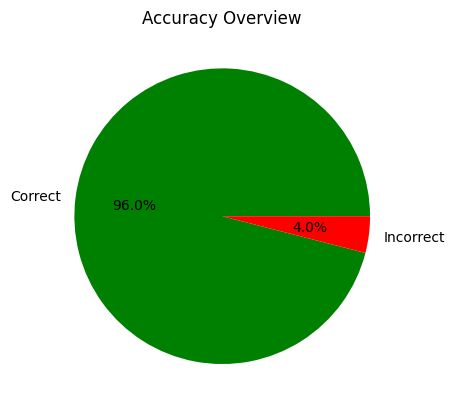

In [ ]:
# 1. Pie Chart for Accuracy
correct = (df_evaluated['atla_score'] == df_evaluated['score']).sum()
incorrect = (df_evaluated['atla_score'] != df_evaluated['score']).sum()
plt.pie([correct, incorrect],
        labels=['Correct', 'Incorrect'],
        colors=['green', 'red'],
        autopct='%1.1f%%')
plt.title('Accuracy Overview')

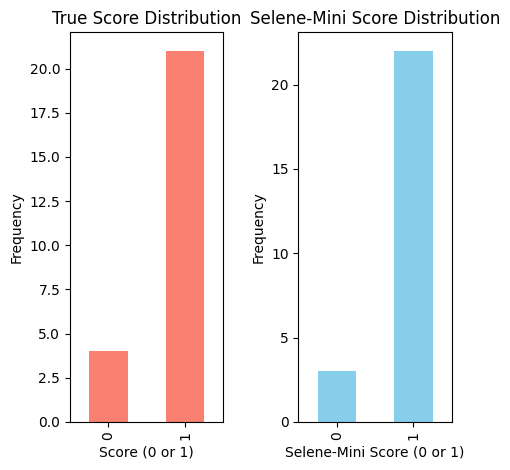

In [ ]:
# 2. Distribution Plots
plt.subplot(132)
df_evaluated['score'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('True Score Distribution')
plt.xlabel('Score (0 or 1)')
plt.ylabel('Frequency')
plt.xticks([0, 1], [0, 1])

plt.subplot(133)
df_evaluated['atla_score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Selene-Mini Score Distribution')
plt.xlabel('Selene-Mini Score (0 or 1)')
plt.ylabel('Frequency')
plt.xticks([0, 1], [0, 1])

plt.tight_layout()
plt.show()

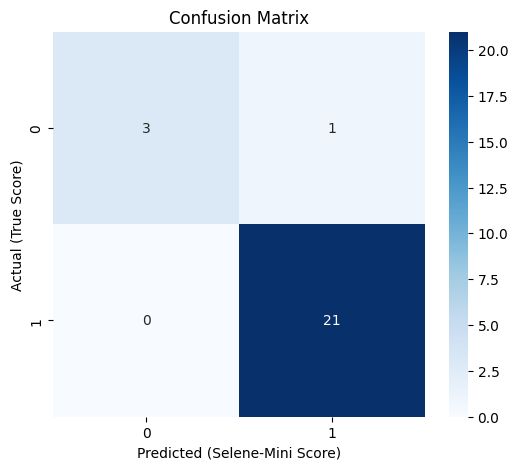

In [ ]:
# 3. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm = confusion_matrix(df_evaluated['score'], df_evaluated['atla_score'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted (Selene-Mini Score)')
plt.ylabel('Actual (True Score)')
plt.show()